In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Replace this with your actual dataset path
data_dir = '/content/drive/MyDrive/Flowers_dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
os.listdir(data_dir)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Task 1 — Dataset overview & **counts**

In [ ]:
import os
from collections import Counter

# Replace this with your actual dataset path

data_dir = '/content/drive/MyDrive/Flowers_dataset'
classes = sorted(os.listdir(data_dir))
print("Classes:", classes)

counts = {c: len(os.listdir(os.path.join(data_dir,c))) for c in classes}
print("Counts per class:", counts)


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Counts per class: {'daisy': 501, 'dandelion': 646, 'roses': 497, 'sunflowers': 495, 'tulips': 607}


Task 2 — Show 3 sample images per **class**

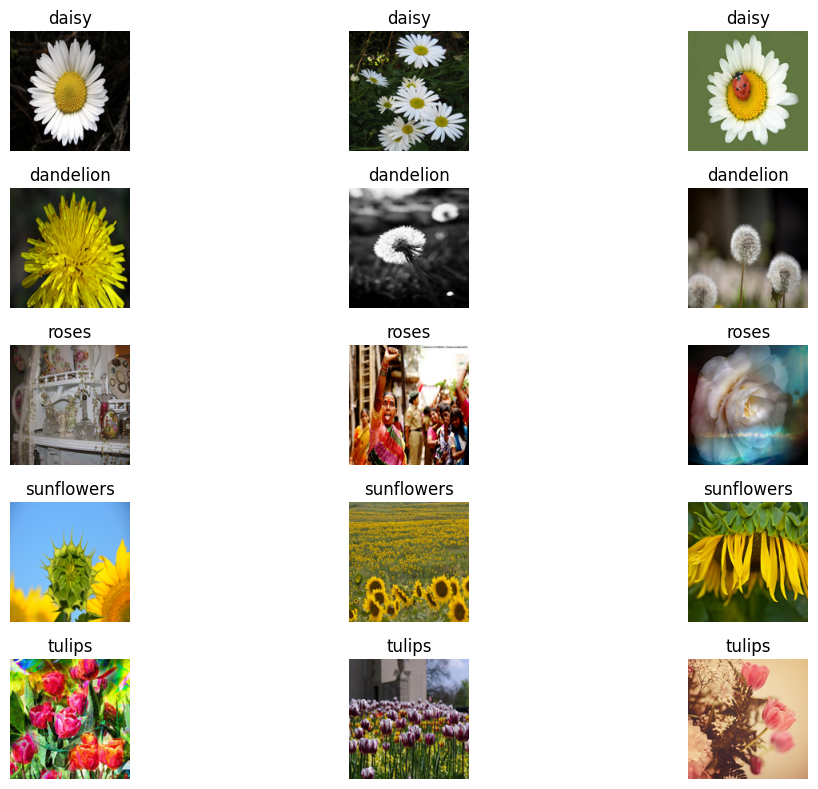

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(12,8))

i=1
for c in classes:
  imgs = os.listdir(os.path.join(data_dir,c))[:3]
  for imname in imgs:
    img = Image.open(os.path.join(data_dir,c,imname)).convert('RGB')
    plt.subplot(len(classes),3,i); plt.axis('off'); plt.title(c)
    plt.imshow(img.resize((150,150)))
    i+=1
plt.tight_layout()


Task 3 — Create train/validation **generators**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG=150; BATCH=32
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                             rotation_range=20, zoom_range=0.2, horizontal_flip=True)

train_gen = datagen.flow_from_directory(data_dir, target_size=(IMG,IMG),
                                        batch_size=BATCH, subset='training', shuffle=True)
val_gen   = datagen.flow_from_directory(data_dir, target_size=(IMG,IMG),
                                        batch_size=BATCH, subset='validation', shuffle=False)


Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


Task 4 — Build simple **CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
  Conv2D(32,(3,3),activation='relu',input_shape=(IMG,IMG,3)), MaxPooling2D(),
  Conv2D(64,(3,3),activation='relu'), MaxPooling2D(),
  Conv2D(128,(3,3),activation='relu'), MaxPooling2D(),
  Flatten(),
  Dense(128,activation='relu'), Dropout(0.5),
  Dense(len(classes), activation='softmax')
])
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,997 (18.42 MB)

 Trainable params: 4,828,997 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Task 5 — Train (with checkpoint & early stop)**bold text**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

chk = ModelCheckpoint('best_flowers.h5', save_best_only=True, monitor='val_loss')
es  = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[chk,es])


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3486 - loss: 1.4611 

69/69 ━━━━━━━━━━━━━━━━━━━━ 1489s 22s/step - accuracy: 0.3496 - loss: 1.4592 - val_accuracy: 0.5146 - val_loss: 1.1717
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5288 - loss: 1.1214

69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 426ms/step - accuracy: 0.5291 - loss: 1.1213 - val_accuracy: 0.5547 - val_loss: 1.1213
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6017 - loss: 1.0215

69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 421ms/step - accuracy: 0.6018 - loss: 1.0212 - val_accuracy: 0.5894 - val_loss: 0.9850
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6562 - loss: 0.9211

69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 429ms/step - accuracy: 0.6561 - loss: 0.9211 - val_accuracy: 0.6241 - val_loss: 0.8908
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 484ms/step - accuracy: 0.6656 - loss: 0.8736 - val_accuracy: 0.6478 - val_loss: 1.0456
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 417ms/step - accuracy: 0.6990 - loss: 0.7952 - val_accuracy: 0.6314 - val_loss: 0.9235
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6831 - loss: 0.8424

69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 439ms/step - accuracy: 0.6834 - loss: 0.8415 - val_accuracy: 0.6515 - val_loss: 0.8250
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 424ms/step - accuracy: 0.7234 - loss: 0.7145 - val_accuracy: 0.6697 - val_loss: 0.8827
Epoch 9/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7242 - loss: 0.6925

69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 501ms/step - accuracy: 0.7244 - loss: 0.6924 - val_accuracy: 0.6989 - val_loss: 0.7831
Epoch 10/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7438 - loss: 0.6513

69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 440ms/step - accuracy: 0.7437 - loss: 0.6517 - val_accuracy: 0.6898 - val_loss: 0.7780
Epoch 11/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 430ms/step - accuracy: 0.7532 - loss: 0.6554 - val_accuracy: 0.6697 - val_loss: 0.8484
Epoch 12/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 425ms/step - accuracy: 0.7567 - loss: 0.6202 - val_accuracy: 0.6861 - val_loss: 0.7857
Epoch 13/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 497ms/step - accuracy: 0.7809 - loss: 0.6091 - val_accuracy: 0.7117 - val_loss: 0.8049
Epoch 14/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8020 - loss: 0.5561

69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - accuracy: 0.8017 - loss: 0.5565 - val_accuracy: 0.7226 - val_loss: 0.7769
Epoch 15/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 421ms/step - accuracy: 0.7804 - loss: 0.5664 - val_accuracy: 0.7026 - val_loss: 0.8114


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/MyDrive/Flowers_dataset/daisy/' + os.listdir(os.path.join(data_dir,'daisy'))[0]
img = image.load_img(img_path, target_size=(IMG,IMG))
x = np.expand_dims(image.img_to_array(img)/255., 0)
pred = model.predict(x)
print("pred_idx:", np.argmax(pred), "class_map:", train_gen.class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
pred_idx: 0 class_map: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


Accuracy & Loss **Graphs**

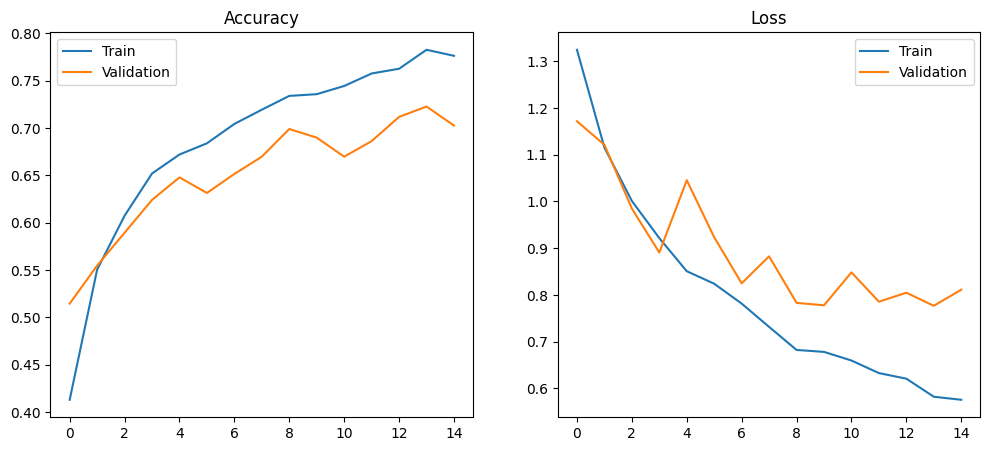

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.show()


Visualize Predicted vs **Actual**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


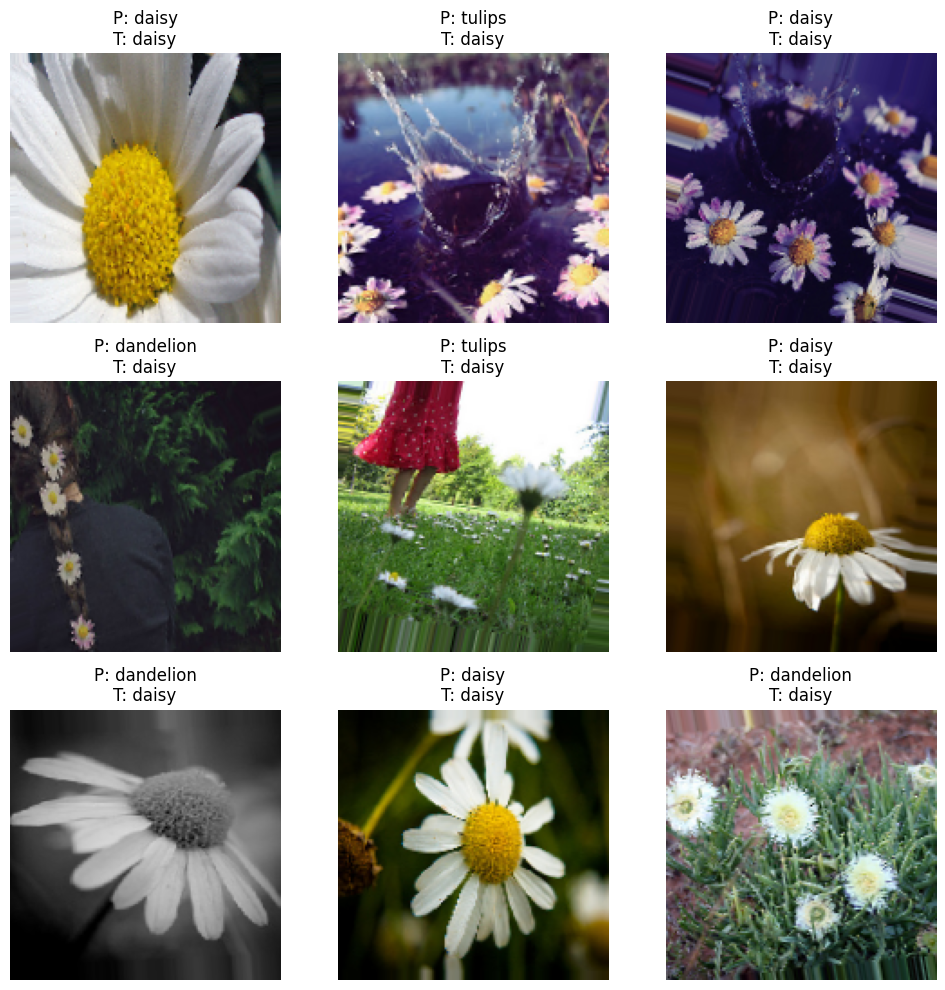

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x, y = next(val_gen)
preds = model.predict(x)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y, axis=1)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x[i])
  plt.axis('off')
  plt.title(f"P: {class_names[pred_labels[i]]}\nT: {class_names[true_labels[i]]}")
plt.tight_layout()


**Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


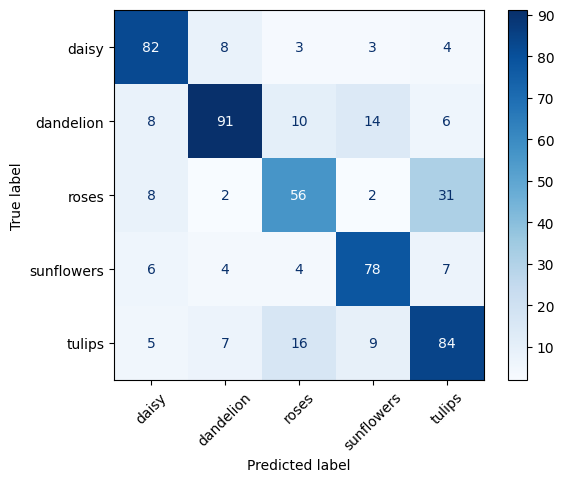

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
for i in range(len(val_gen)):
  Xb, yb = val_gen[i]
  y_true.extend(np.argmax(yb, axis=1))
  y_pred.extend(np.argmax(model.predict(Xb), axis=1))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45, cmap='Blues')
plt.show()


**Transfer Learning (Model Improvement)**

***Import and prepare base model***

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (150,150)

# Load VGG16 without top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze convolution layers


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


***Build transfer learning model***

In [ ]:
model_tl = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 flower classes
])

model_tl.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,381 (64.14 MB)

 Trainable params: 2,098,693 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

***Train model***

In [ ]:
history_tl = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 755ms/step - accuracy: 0.3714 - loss: 1.5443 - val_accuracy: 0.6460 - val_loss: 0.9904
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 489ms/step - accuracy: 0.6549 - loss: 0.9245 - val_accuracy: 0.7117 - val_loss: 0.8284
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 474ms/step - accuracy: 0.7147 - loss: 0.7650 - val_accuracy: 0.7354 - val_loss: 0.7604
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - accuracy: 0.7433 - loss: 0.7011 - val_accuracy: 0.7500 - val_loss: 0.7119
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 460ms/step - accuracy: 0.7641 - loss: 0.6348 - val_accuracy: 0.7372 - val_loss: 0.7021
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 463ms/step - accuracy: 0.7960 - loss: 0.5753 - val_accuracy: 0.7555 - val_loss: 0.6995
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 35s 502ms/step - accuracy: 0.7951 - loss: 0.5477 - val_accuracy: 0.7555 - val_loss: 0.6725
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 477ms/step - accuracy: 0.8043 - loss: 0.5186 - val_accu

***Plot accuracy & loss***

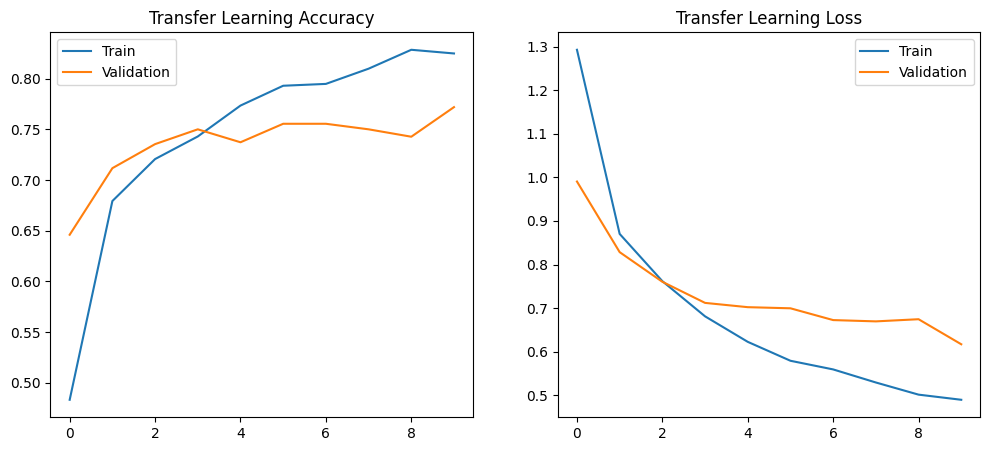

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_tl.history['accuracy'], label='Train')
plt.plot(history_tl.history['val_accuracy'], label='Validation')
plt.title('Transfer Learning Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_tl.history['loss'], label='Train')
plt.plot(history_tl.history['val_loss'], label='Validation')
plt.title('Transfer Learning Loss')
plt.legend()
plt.show()


***Visualize Predicted vs Actual***

***Visualize Predicted vs Actual***

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


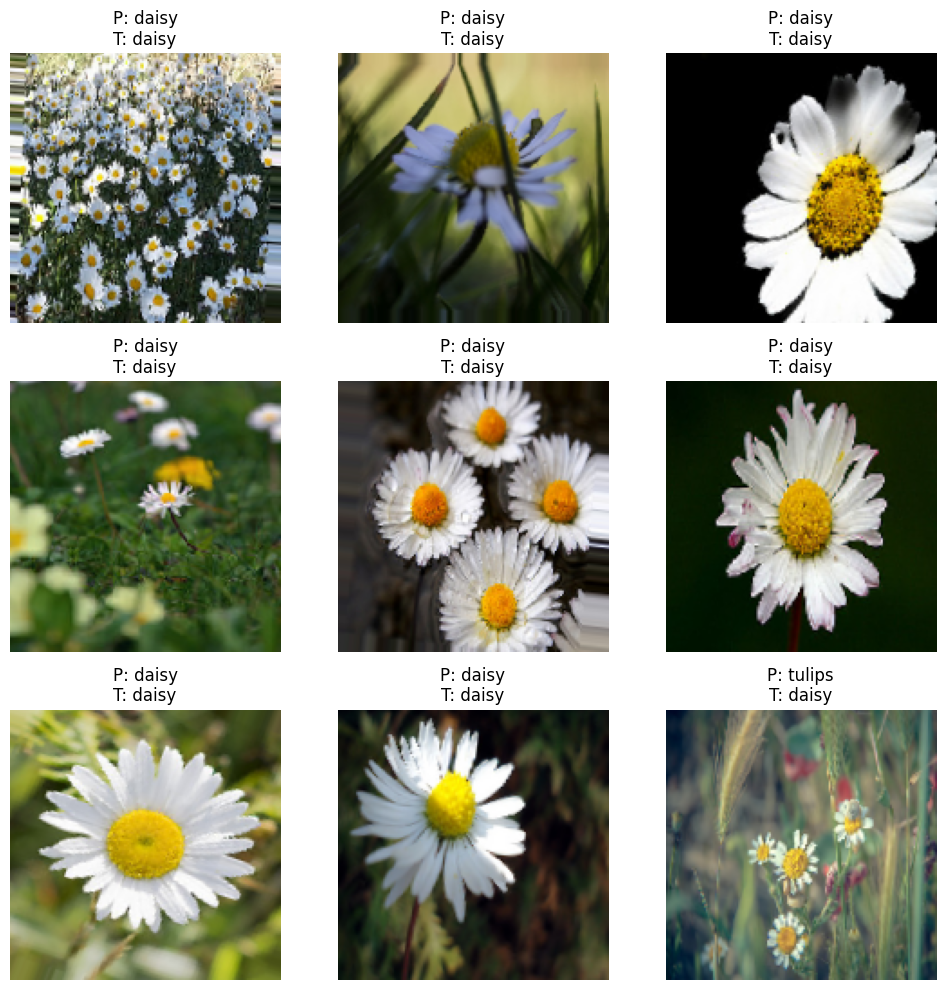

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_batch, y_batch = next(val_gen)
preds = model_tl.predict(x_batch)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_batch, axis=1)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_batch[i])
  plt.axis('off')
  plt.title(f"P: {class_names[pred_labels[i]]}\nT: {class_names[true_labels[i]]}")
plt.tight_layout()
plt.show()


***Confusion Matrix***

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


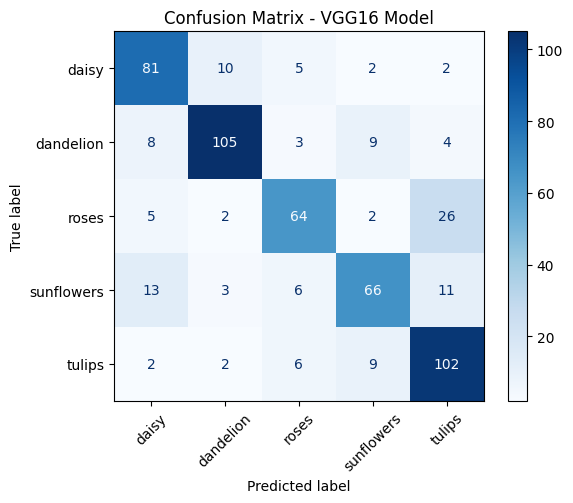

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
for i in range(len(val_gen)):
    Xb, yb = val_gen[i]
    preds = model_tl.predict(Xb)
    y_true.extend(np.argmax(yb, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - VGG16 Model")
plt.show()


**`Evaluate & Save`**

In [ ]:
model_tl.evaluate(val_gen)
model_tl.save('/content/drive/MyDrive/Flowers_VGG16_model.h5')


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.7814 - loss: 0.5810


In [ ]:
from google.colab import files
files.download('Flowers_VGG16_model.h5')


FileNotFoundError: Cannot find file: Flowers_VGG16_model.h5